# Training

In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from vae_based_medical_image_generator.data import dataset
from torch.utils.data import DataLoader
from vae_based_medical_image_generator.model.vae import EncoderVAE, DecoderVAE, VariationalAutoencoder, vae_loss

# Define hyperparameters for training
img_channels = 1
feature_dim = 32*20*20
latent_dim = 100

batch_size = 32
lr = 1e-3
num_epochs = 1_000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# initialize the encoder and the decoder

encoder = EncoderVAE(img_channels, feature_dim, latent_dim) 
decoder = DecoderVAE(img_channels, feature_dim, latent_dim)
vae = VariationalAutoencoder(encoder, decoder, device).to(device)



In [3]:
# initialize dataset
train_dataset = dataset.load_dataset(dataset_name="chestmnist", split="train")
test_dataset  = dataset.load_dataset(dataset_name="chestmnist", split="test")

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)


# initialize optimizer and scheduler
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_loader)*50, gamma=0.5, last_epoch=- 1, verbose=False) 

Using downloaded and verified file: /home/workstation/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/workstation/.medmnist/chestmnist.npz


In [4]:
def print_image(vae, dataloader, device):
    vae.eval()
    with torch.no_grad():
        for data in random.sample(list(dataloader), 1):
            imgs, _ = data
            imgs = imgs.to(device)
            img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
            plt.subplot(121)
            plt.imshow(np.squeeze(img))
            out, mu, logVAR = vae(imgs)
            outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
            plt.subplot(122)
            plt.imshow(np.squeeze(outimg))
    plt.show()

        

Epoch 1:   0%|          | 0/2453 [00:00<?, ?batch/s]

Epoch 5: 100%|██████████| 2453/2453 [00:06<00:00, 369.15batch/s]


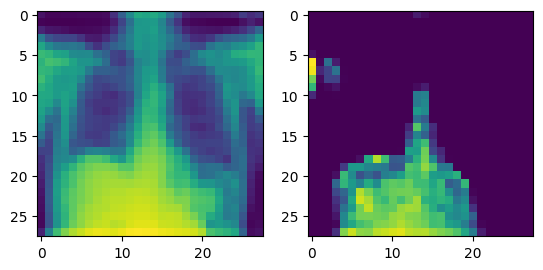

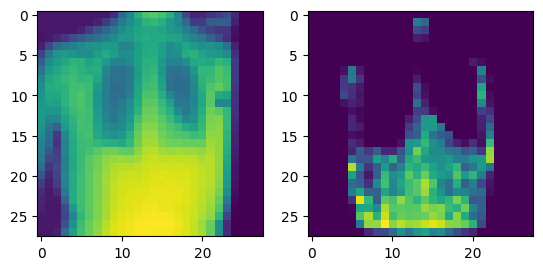

Epoch 10: 100%|██████████| 2453/2453 [00:06<00:00, 373.53batch/s]


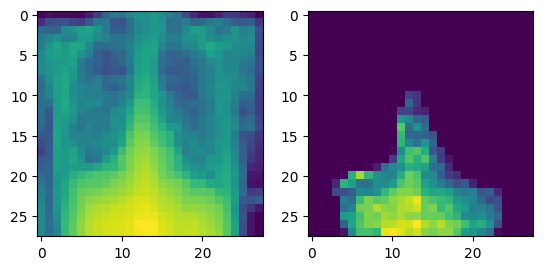

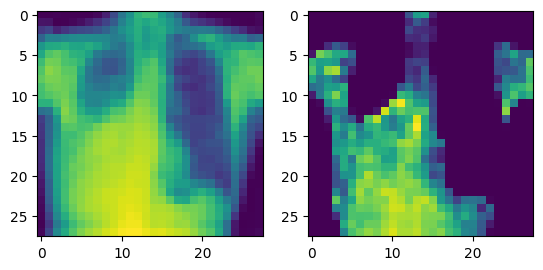

Epoch 15: 100%|██████████| 2453/2453 [00:06<00:00, 368.59batch/s]


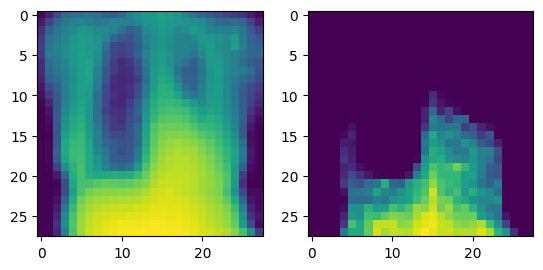

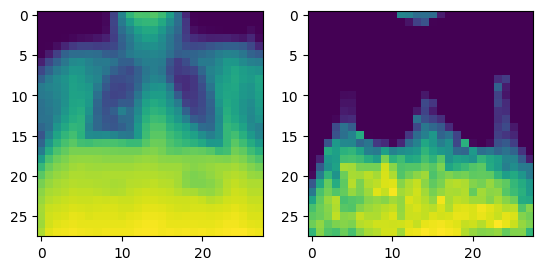

Epoch 20: 100%|██████████| 2453/2453 [00:06<00:00, 366.01batch/s]


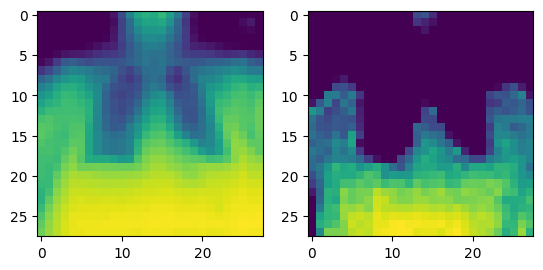

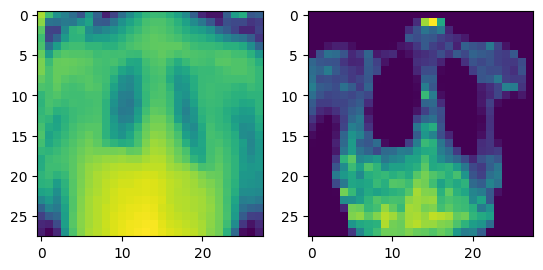

Epoch 21: 100%|██████████| 2453/2453 [00:06<00:00, 373.32batch/s]


KeyboardInterrupt: 

In [5]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
training_losses = [] 
test_losses = [] 
for epoch in range(1, num_epochs +  1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vae.train()
        tepoch.set_description(f"Epoch {epoch} of {num_epochs}, LR: {scheduler.get_last_lr()}")

        loss_per_epoch = 0

        for data in tepoch:
            imgs, _ = data
            imgs = imgs.to(device)
            
            out, mu, logVar = vae(imgs)
            training_loss = vae_loss(imgs, out, mu, logVar) 

            loss_per_epoch += training_loss.item()

            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()
            scheduler.step()

        training_losses.append(loss_per_epoch/len(train_loader.dataset))


    # visualize a sample from the training and test loader every 5 iterations
    if epoch % 5 == 0:
        print_image(vae, train_loader, device)
        print_image(vae, test_loader, device)


    # Evaluation loop
    vae.eval()  # Set the model to evaluation mode
    test_loss = 0
    total_samples = 0

    with torch.no_grad():
        for data in test_loader:
            test_imgs, _ = data
            test_imgs = test_imgs.to(device)

            test_out, test_mu, test_logVar = vae(test_imgs)
            test_loss += vae_loss(test_imgs, test_out, test_mu, test_logVar).item()

        
        test_losses.append(test_loss/len(test_loader.dataset))



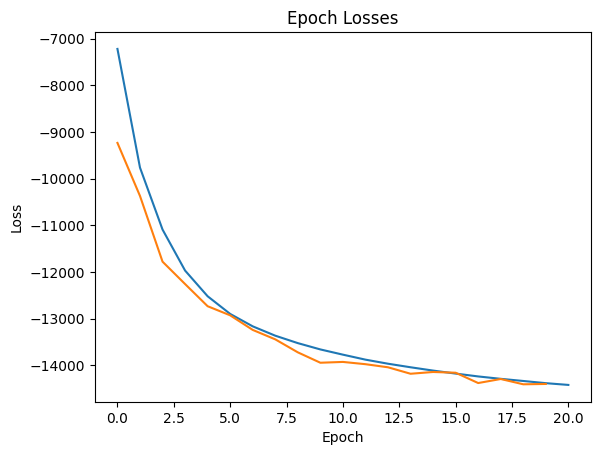

In [8]:
import matplotlib.pyplot as plt


### Plot training losses
# Create a line plot of the epoch losses
plt.plot(training_losses, label = "Training loss")
plt.plot(test_losses, label = "Test loss")
# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses')

# Display the plot
plt.show()